In [1]:
import skimage.io as io
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")  # skimage warns when saving uint16 with not covering full range of 0-65535
example_root = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'examples')

# Train Detectron2 model with PCNA data

__Author: Yifan Gui @ Kuan Yoow Chan group__

__WARNING__: to run the tutorial, make sure you have downloaded pre-trained maskRCNN model [here]()

pcnaDeep relies on __Mask R-CNN__ backbone from Facebook's __Detectron2__ fremework to segment the fluorescent/brightfield image and predict cell cycle stage of each segmentated object. During mitosis entry, after nucleus envelope breakdown, PCNA signal flees from the nucleus into the cytoplasm, leaving itself as dim as the background in a confocal system.
To fix the problem, pcnaDeep take advantages of the bright field image (DIC/phase contrast) in which mitosis cells have clear boundaries as they round up. Hence, the predictor can faithfully tell cycle cycle phase as long as __fluorescent and birght field images are supplied to the model simutaneously__.

## Standard training & annotation data format
The __training image data__ have 2 channels: PCNA fluorescent and the bright field.

- The images should be organized in two separate folders named `mcy` and `dic`.  

- The same as prediction input, images should be `uint16` format `tif`.

The __training annotation data__ adpots the __`json`__ format of __VGG Image Annotator (VIA2)__, in which points delineating the contour of a region, plus the region label (cell cycle phase). 

---

## 1. Generate training data from raw image stacks

In this tutorial we will use a 5-frame toy data chosen from a 24hr time-lapse RPE1 imaging dataset.

In [2]:
# Raw image stacks
bf = io.imread(os.path.join(example_root, 'RPE', 'RPE_DIC.tif'))
pcna = io.imread(os.path.join(example_root, 'RPE', 'RPE_mCherry.tif')) 
print(bf.shape, pcna.shape)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


(5, 1200, 1200) (5, 1200, 1200)


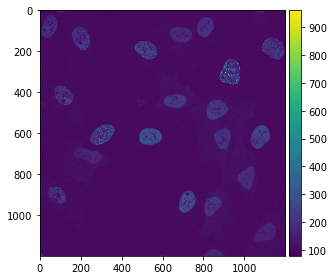

In [3]:
io.imshow(pcna[1,:,:])

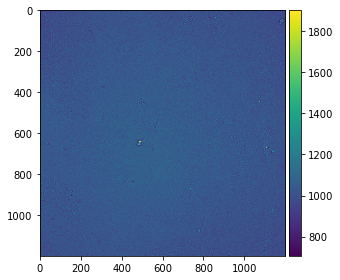

In [4]:
io.imshow(bf[1,:,:])

The stacks have not been scaled. They will be scaled during training run-time for adjusting pre-processing parameters  
- __Saturation percentage `sat`__: If set to 1, then the lowest 1% and highest 1% pixel will be cropped (set to 0 and 255 in the output uint8 image respectively)
- __Gamma__: Gamma correction factor that non-linearly enhance low-intensity pixels.

By default, `sat=1, gamma=1`.

However, we want to have scaled data easy-to-visualise to annotate cells. Therefore we generate composite images using `getDetectInput` that adopts two pre-processing parameters as above. 

In [5]:
from pcnaDeep.data.utils import getDetectInput
help(getDetectInput)

Help on function getDetectInput in module pcnaDeep.data.utils:

getDetectInput(pcna, dic, gamma=1, sat=1, torch_gpu=False)
    Generate pcna-mScarlet and DIC channel to RGB format for detectron2 model prediction
    
    Args:
        pcna (numpy.ndarray): uint16 PCNA-mScarlet image stack (T*H*W).
        dic (numpy.ndarray): uint16 DIC or phase contrast image stack.
        gamma (float): gamma adjustment, >0, default 0.8.
        sat (float): percent saturation, 0~100, default 0.
        torch_gpu (bool): use torch to speed up calculation.
    
    Returns:
        (numpy.ndarray): uint8 composite image (T*H*W*C)



In [6]:
comp = getDetectInput(pcna=pcna, dic=bf, gamma=1, sat=1)

Saturation: 1, Gamma 1
Shape:  (5, 1200, 1200, 3)


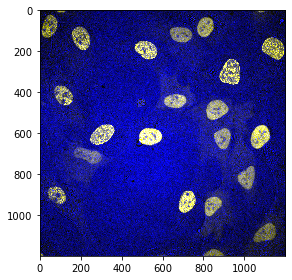

In [7]:
io.imshow(comp[1,:,:])

### 1.2 Save composite image stack as `png` slices for labeling
__VIA2 can only read single `uint8 png` images__, therefore, we must convert image stacks to this through __`pcnaDeep.data.annotate.save_seq( )`__.

__REMINDER:__ Both pcnaDeep detectron2 model and `pcnaDeep.data.annotate.mask2json( )` outputs `json` in which file name following the following naming rule, which must be considered when calling `save_seq( )` so that file names in `json` matches real images:

|prefix|-|000x (frame)|format|
|---|---|---|---|
|stack|-|0000|.png|

_Note:_ The frame counts from 0.


In [8]:
from pcnaDeep.data.annotate import save_seq
help(save_seq)

Help on function save_seq in module pcnaDeep.data.annotate:

save_seq(stack, out_dir, prefix, dig_num=3, dtype='uint16', base=0, img_format='.tif', keep_chn=True, sep='-')
    Save image stack and label sequentially.
    
    Args:
        stack (numpy array) : image stack in THW format (Time, Height, Width).
        out_dir (str) : output directory.
        prefix (str) : prefix of single slice, output will be prefix-000x.tif/png.
            (see sep below for separator).
        dig_num (int) : digit number (3 -> 00x) for labeling image sequentially.
        dtype (numpy.dtype) : data type to save, either 'uint8' or 'uint16'.
        base (int) : base number of the label (starting from).
        img_format (str): image format, '.tif' or '.png', remind the dot.
        keep_chn (bool): whether to keep full channel or not.
        sep (str): separator between file name and id, default '-'.



Our composite stack has three channels; whether to label on brightfield + PCNA channels or only PCNA channel depends on personal choice. Some may find composite image easier to label mitosis, some (especially experienced ones) may think single channel is tidier. 

Switch whether to save three channels or the first one (PCNA) using `keep_chn` parameter. 

In [9]:
save_seq(comp, os.path.join(example_root, 'RPE', 'label'), 
        prefix='RPE', dtype='uint8', dig_num=4, base=0, img_format='.png', keep_chn=True)

### 1.3 Save raw image stacks as `tif` slices for training

Similarly, raw stacks of the two channels are saved as `uint16` slices under `mcy` and `dic` folders. 

__The file name should be exactly the same as labeling files (above), except that `tif` suffix replaces `png`__. The model will resolve file name in `json` (ends with `png`) automatically.

In [10]:
save_seq(pcna, os.path.join(example_root, 'RPE', 'mcy'), 
        prefix='RPE', dtype='uint16', dig_num=4, base=0, img_format='.tif', keep_chn=True)
save_seq(bf, os.path.join(example_root, 'RPE', 'dic'), 
        prefix='RPE', dtype='uint16', dig_num=4, base=0, img_format='.tif', keep_chn=True)

---
## 2. Annotate training data
### 2.1 (option A, recommanded) Acquire mask & classification from pretrained model prediction
It is suggested to begin annotation from pretrained model __`.json`__ output, which is compatible with and can be imported to __VGG Image Annotator 2 (VIA2)__.

__`detect.py`__ is a handy script to do the job. It takes in similar paramters as `main.py`, but not those for tracking and cell cycle profiling. 

__`detect.py`__ takes raw image stacks as the input and preprocessing parameters.

- --pcna: raw PCNA channel image stack.
- --bf: raw bright field channel image stack.
- --sat: saturation factor.
- --gamma: gamma correction factor.
- --prefix: image prefix, __should be the same used in `save_seq` above__.
- --opts MODEL.WEIGHTS: change pretrained model in the config in a detectron2 fashion.

Moreover, `detect.py` directly outputs a `json` file.

In [11]:
# Generate command
script_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'bin', 'detect.py')
config_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'config', 'dtrnCfg.yaml')
input_dic_path = os.path.join(example_root, 'RPE', 'RPE_DIC.tif')
input_pcna_path = os.path.join(example_root, 'RPE', 'RPE_mCherry.tif')
output_path = os.path.join(example_root, 'RPE')
model_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'models', 'mrcnn_sat_rot_aug.pth')
paths = list(map(lambda x:"\""+x+"\" ", [script_path, config_path, input_dic_path, input_pcna_path, output_path, model_path]))
command = 'python ' + paths[0] + '--config-file ' + paths[1] + '--bf ' + paths[2] + '--pcna ' + paths[3] + \
    '--prefix RPE ' + '--output ' + paths[4]+ '--opts MODEL.WEIGHTS ' + paths[5]
#print(command)

_Note:_ You can always __run through commandline (recommended)__. 

_Advanced:_ `--vis_out` tells the machine to output standard detectron2 visualisation image (raw superimposed with object detectron) will be output, which requires `opencv` installation.

In [12]:
# run detection
os.system(command)

0

### 2.1 (option B) Acquire mask from conventional segmentation (for _de novo_ labeling)
Another approach is to generate mask from conventional segmentation methods, i.e., thresholding. Common processing pipeline includes Gaussian-filtering, thresholding, open-calculation, gap-filling, small partical-removing. __Fiji software__ can efficiently do this on batch. Below is a reference __macro__ performing segmentation on PCNA channel _ONLY_. 

`
run("Enhance Contrast...", "saturated=1");
run("Gaussian Blur...", "sigma=2");
setAutoThreshold("Default dark");
setOption("BlackBackground", false);
run("Convert to Mask");
run("Open");
run("Fill Holes");
run("Analyze Particles...", "size=1000-Infinity show=Masks");
run("Adjustable Watershed", "tolerance=4");
run("Invert LUT");
`

_Note:_ __Output must be saved in `.png` format.__

_Note:_ [`Adjustable Watershed`](https://imagejdocu.tudor.lu/plugin/segmentation/adjustable_watershed/start) is an optional plugin, because fiji build-in watershed sometimes oversegments the mask.

_Note:_ In this way, no cell cycle classification can be _automatically_ labeled, and another round of conversion is required to generate VIA2-readable `.json` file.

To generate `.json` from mask, __`pcnaDeep.data.utils.mask2json( )`__ scans masks from the input directory and records all contours of objects in a mask into a `.json` file. The mask file name in this file is kept the same as original one. Although the function can interpret cell cycle phase from labeled mask through the default mapping `{10:"G1/G2", 50:"S", 100:"M", 200:'E'}` when method parameter `phase_labeled=True`, it is not recommended to label them from this step. `mask2json( )` sets the default classification as `'G1/G2'`.

In [13]:
from pcnaDeep.data.utils import mask2json
help(mask2json)

Help on function mask2json in module pcnaDeep.data.utils:

mask2json(in_dir, out_dir, phase_labeled=False, phase_dic={10: 'G1/G2', 50: 'S', 100: 'M', 200: 'E'}, prefix='object_info')
    Generate VIA2-readable json file from masks
    
    Args:
        in_dir (str): input directory of mask slices in .png format. Stack input is not implemented.
        out_dir (str): output directory for .json output
        phase_labeled (bool): whether cell cycle phase has already been labeled. 
            If true, a phase_dic variable should be supplied to resolve phase information.
        phase_dic (dic): lookup dictionary of cell cycle phase labeling on the mask.
        prefix (str): prefix of .json output.
    
    Outputs:
        prefix.json in VIA2 format. Note the output is not a VIA2 project, so default image directory
            must be set for the first time of labeling.



In [14]:
mask2json(in_dir = os.path.join(example_root, 'RPE', 'Fiji_mask'), 
          out_dir = os.path.join(example_root, 'RPE'),
          phase_labeled = False,
          prefix = 'RPE_fiji')

The code generates file `RPE_stack.json` that is readable by VIA2.

### 2.2 Import, correct classification and segmentation through VIA2 software

Open VIA2 software, default path of the image folder should be set through __Settings > Default Path__. (only once for annotating one dataset) In our case, it will be '\<PATH TO PROJECT ROOT\>/pcnaDeep/examples/RPE/label/'. Press __Save__ at the bottom of settings. Import `json` annotation file through __Annotations > Import Annotations (from json)__. You should see the following interface. If no, check path setting and the matching between file name in json file and the raw data.

![demo](assets/via2_1.png)

Following [VIA2 instructions](https://www.robots.ox.ac.uk/~vgg/software/via/) to get familiar with the tool. You may find toggle labeling (keyboard: space), remove region (keyboard: d) useful.

---
#### To correct cell boundaries and classifications, here are specific __guidelines__:
1. Cells should be labeled as __G1/G2, S, M, or E__. 
   - __G1/G2__ means the region is either G1 or G2. Although PCNA expression level is high in G2 and low in G1, we do not expect the model to identify this due to the variability of the illumination conditions.
   - __E__ means 'emergine' from the mitosis, where the nuclear envelope has already formed, but signal intensity between the nucleus and the cytoplasm is similar (low contrast).
   - __M__ as mitosis, defined from nuclear envelope break down to the reformation of nuclear envelope. Mitosis cells can be clearly discerned from brightfield image as they round up.
   - __S__ phase is characterized by granule-like distribution of PCNA protein in the nucleus. When there are more than 3 clear foci, the nucleus can be classificed as S.
   
   &emsp;Here are some examples of each class.
   
   ![demo](assets/cls_demo.png)
   
   __(1)__ Typical label of __G1/G2__ and __S__ phase cells  
   __(2)__ An example of __unlabeled mitosis cell__ (in red). After drawing cell boundary, need to specify cell cycle phase.  
   __(3)__ Two typical __mitosis cells__. The upper left has already passed cytokinesis while the lower left has just passed nuclear envelope breakdown. Note the upper left contains an overlapped detection which should be erased. 3a and 3b are comparsions between PCNA-only channel and PCNA/brightfield composite.  
   __(4)__ The synchrogram of a __complete mitosis process__ (cell referred is labeled with a triangle and arbitrary track shown as dashed line). Note the slight __difference between E and G1/G2__. E has more cytoplasm background compared with typical G1/G2. However, because E and G1/G2 will be assigned with G1/G2 during cell cycle resolving, such labeling does not need to be very precise, as long as it facilitates the machine to learn.
   
   
2. If unsure about cell cycle phase, check raw time-lapse with temporal information.


3. Boundary labeling does not need to be extremely precise; typically 20 points is enough to delineate a nucleus of MCF10A/RPE1 cells under 60X.


4. Label as much as you can, if you cannot discern, neither the computer.


5. Sometimes the model outputs overlapped regions which should be deleted, be careful to them

---
To save current progress, use __Project > Save__ to save the VIA2 project. Next time you may directly open the project without configuring the image path through __Project > Load__.

Once all the labeling is finished, use __Annotations > Export Annotations (as json)__ to get standard `json` file used in pcnaDeep.

---
## 3. Organize data path and config model training set

Once you have your input images and annotation `.json` file. Organize them in an informative way. 

E.g.

|----ROOT

&emsp;|----MCF10A_s1

&emsp;&emsp;|---mcy  
&emsp;&emsp;&emsp;|---MCF10A_s1-0001.tif  
&emsp;&emsp;&emsp;|---MCF10A_s1-0002.tif  
&emsp;&emsp;|---dic  
&emsp;&emsp;&emsp;|---MCF10A_s1-0001.tif  
&emsp;&emsp;&emsp;|---MCF10A_s1-0002.tif

&emsp;|----MCF10A_s1.json

According to the repository, config the training script `train_detectron2.py` from line 209:

(line 209) `DATASET_ROOT = 'ROOT'`

(line 210) `TRAIN_PREFIX = ['MCF10A_s1']`

The module `pcnaDeep.data.preparePCNA` will resolve these inputs to feed into detectron2 model.

You will need to specify testing set in `TEST_PREFIX` (line 211).

---

`train_detectron2.py` is a __plain training schedule modified from Detectron2 offical demo__, which training from Detectron2's Mask R-CNN model baseline. To train from pcnaDeep pretrained model, change the following config:

(line 164) `cfg.merge_from_file("../config/dtrnCfg.yaml")`

(line 165) `cfg.MODEL.WEIGHTS = "../models/mrcnn_sat_rot_aug.pth"`

_Note:_ You can always specify detectron2 configurations from commandline by `--opts`, or modify `yaml` directly.

_None:_ Other configurations, including iteration time, learning rate, augmentation etc. are shown in function `setup( )` Plase check [Detectron2 config references](https://detectron2.readthedocs.io/en/latest/modules/config.html?highlight=config#config-references) for details.

---
## 4. Train model

Run `train_detectron2.py` from the commandline:

`python train_detectron2.py --num-gpus 1`